In [ ]:
# Kết nối với gg drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### Giải nén file dataset

In [ ]:
zip_path = '/content/gdrive/My Drive/Computer Vision course/HGR-CNN pho bien/data_HGR.zip'
!cp "{zip_path}" .
!unzip -q TeachingAssigntant_HGR1.zip
!rm TeachingAssigntant_HGR1.zip

### Import các thư viện cần thiết

In [ ]:
import tensorflow as tf
import keras 
from keras.models import load_model, Input, Model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Add
from tensorflow.keras.applications import *
import os
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

### Load dữ liệu

#### Đường dẫn đến train, val, test set

In [ ]:
train_path = "/content/TeachingAssigntant_HGR1/train"
test_path = "/content/TeachingAssigntant_HGR1/test"
val_path = "/content/TeachingAssigntant_HGR1/val"

#### Xem qua 1 số ảnh kết quả segment 

In [ ]:
def show_image(dataset_path):
  image_list = []
  for folder in os.listdir(dataset_path):
    image_path = os.path.join(os.path.join(dataset_path, folder), os.listdir(os.path.join(dataset_path, folder))[0])
    image_list.append([cv2.imread(image_path), folder])
  plt.subplots(figsize = (10, 10))
  for i in range(14):
    plt.subplot(1, 14, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_list[i][0])
    plt.xlabel(image_list[i][1])
  plt.show()

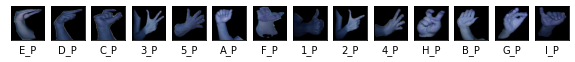

In [ ]:
show_image(train_path)

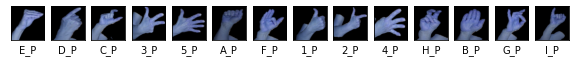

In [ ]:
show_image(val_path)

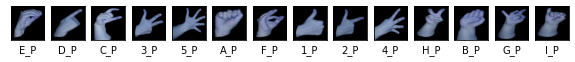

In [ ]:
show_image(test_path)

#### Data augment

In [ ]:
# preprocessing_function = lambda x: x/255.0*2 - 1
train_datagen = ImageDataGenerator(
    rescale=1./255,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    zoom_range = [0.7, 1.7],
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [ ]:
train_data = train_datagen.flow_from_directory(train_path, target_size = (224, 224), batch_size = 32, class_mode ="categorical")
val_data = test_datagen.flow_from_directory(val_path, target_size = (224, 224), batch_size = 32, class_mode ="categorical")
test_data = test_datagen.flow_from_directory(test_path, target_size = (224, 224), batch_size = 32, class_mode ="categorical")

Found 407 images belonging to 14 classes.
Found 27 images belonging to 14 classes.
Found 28 images belonging to 14 classes.


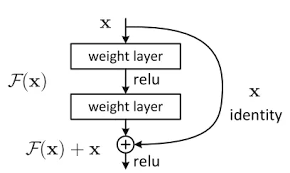

### Resnet50

In [ ]:
def ResNet50_HGR1(input_shape = (224, 224, 3)):
  input = Input(shape = input_shape)
  based_model = ResNet50(include_top=False, weights = None, input_tensor=input).output
  x = GlobalAveragePooling2D()(based_model)
  x = Dense(128, activation="relu", kernel_initializer= "he_normal")(x)
  x = Dropout(0.3)(x)
  output = Dense(14, activation= "softmax", kernel_initializer='he_normal')(x)
  model = Model(inputs = input, outputs = output)
  # model = Model(inputs = [input1, input2], outputs = [output,output1])
  model.summary()
  return model

In [ ]:
resnet50 = ResNet50_HGR1()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
resnet50.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(min_lr=0.00001), ModelCheckpoint("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/resnet/resnet_{epoch:}_{val_accuracy:}.hdf5", monitor="val_accuracy", save_best_only=True)]

In [ ]:
resnet50 = load_model("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/resnet/resnet_470_0.48148149251937866.hdf5")
resnet50.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(min_lr=0.00001), ModelCheckpoint("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/resnet/resnet_{epoch:}_{val_accuracy:}.hdf5", monitor="val_accuracy", save_best_only=True)]

In [ ]:
steps_per_epoch = 407//32 + 1
validation_step = 27//32 + 1
history = resnet50.fit(train_data, batch_size=32, validation_batch_size=32, epochs = 930, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback, initial_epoch=470)

In [ ]:
model = load_model("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/resnet/resnet_783_0.7407407164573669.hdf5")

In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 13s 13s/step - loss: 0.8931 - accuracy: 0.6429


[0.893097996711731, 0.6428571343421936]

### **Transfer Learning (Chuyển giao tri thức)**

1.   *Lí do cần áp dụng Transfer Learning trong bài này*
- Như chúng ta thấy trong bài này, bộ dữ liệu trong bài này của chúng ta rất nhỏ với chỉ 454 ảnh gồm 14 class khác nhau (mỗi class ~ 31 ảnh) cho dữ liệu train và 28 ảnh cho tập test.
- Không chỉ thế, chúng ta còn phải chia dữ liệu huấn luyện thành hai phần cho tập train chính thức (train: 407 ảnh) và tập xác thực (val: 27 ảnh).
- Do đó, mô hình của chúng ta (Resnet50) sẽ khó học được các đặc trưng tổng quát cho việc phân loại các cử chỉ tay. Từ đó, khi test độ chính xác trên những bộ dữ liệu mới độ chính xác sẽ bị giảm.
- Đặc biệt, mô hình Resnet50 mà chúng ta đang sử dụng cũng là một mô hình rất phức tạp. Với bộ dữ liệu lớn thì không sao. Tuy nhiên, bộ dữ liệu của chúng ta lại rất nhỏ, từ đó độ chính xác của mô hình sẽ bị giảm. Hiện tượng overfit dễ xảy ra.
2.   *Transfer Learning trong bài này*
- 4 tình huống thưởng gặp khi sử dụng Transfer Learning:
  + Bài toán mới của mình dùng có bộ dữ liệu lớn giống bộ dữ liệu mình pretrain model: Trường hợp tốt nhất
  + Gặp bộ dữ liệu mới lớn và khác bộ dữ liệu minh dùng pretrain: Thường thì người ta sẽ huấn luyện lại từ đầu 
  + Bộ dữ liệu nhỏ và giống bộ dữ liệu mình pretrained: Thường sử dụng cho trường hợp này thì chỉ cần bỏ các lớp fully connect ở cuối model
  + Bộ dữ liệu nhỏ và khác bộ dữ liệu của mình: ngoài việc mà mình loại bỏ các lớp fully connected ở cuối thì cũng có thể loại bỏ các lớp mà trích xuất ra các đặc trưng high level
- Như chúng ta biết thì bộ dữ liệu ImageNet là một bộ dữ liệu lớn với 1000 class khác nhau. Vậy chúng ta sẽ sử dụng mạng pretrained Resnet50 với weights của ImageNet trong bài này.
- Trong trường hợp bài này, chúng ta sẽ dùng transfer learning trong trường hợp small dataset, different data. Nên ngoài bỏ các fully connected layers, chúng ta sẽ bỏ thêm một số layer có đặc điểm nhận dạng các đặc điểm phức tạp cao.
3. *Các bước của Transfer Learning*
- Đóng băng các lớp trong based model
- Sau 1 khoảng thời gian mà mình thấy cái model của mình nó hội tụ với data mới rồi thì một fine tuning.








#### Đông băng các lớp trong based model

In [ ]:
base = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
base.trainable = False

#input = Input(shape=(224, 224, 3))
x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x) #0.4
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x) #0.6
output = Dense(14, activation= "softmax", kernel_initializer='he_normal')(x)
transfer = Model(inputs = base.input, outputs = output)
transfer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
transfer.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1, factor=0.1, min_lr=0.00000001), ModelCheckpoint("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/transfer/resnet_freeze1_{epoch:}_{val_accuracy:}.hdf5", monitor="val_accuracy", save_best_only=True)]

In [ ]:
steps_per_epoch = 407//32 + 1
validation_step = 27//32 + 1
history = transfer.fit(train_data, batch_size=32, validation_batch_size=32, epochs = 900, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

#### Gỡ đóng băng các lớp của base (Fine Tuning)

1.   *Fine tuning*
- Đây là một bước không bắt buộc trong transfer learning.
- Được thực hiện khi mà model bạn đã hội tụ trên bộ dữ liệu mới. Chúng ta có thể dựa vào kết quả val_loss và val_acc để xác định xem liệu mô hình đã hội tụ trên dữ liệu mới chưa.
- Bước này có thể dẫn đến overfitting.
2.   *Cách thức thực hiện*
- Trước hết chuyển thuộc tính trainable của các layer trong base sang True và chuyển lr sang thấp tầm 0.000001


In [ ]:
# BatchNormalization --> variance và mean

In [ ]:
for layer in transfer.layers:
  string = layer.name.split("_")
  if "bn" not in string:
    layer.trainable = True

In [ ]:
#bn_layer.trainable = False

In [ ]:
"""
for layer in transfer.layers:
  layer.trainable = True
bn_layer.trainable = False
"""

'\nfor layer in transfer.layers:\n  layer.trainable = True\nbn_layer.trainable = False\n'

In [ ]:
transfer.summary()

In [ ]:
transfer.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=["accuracy"])
my_callback = [ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1, factor=0.1, min_lr=0.00000001), ModelCheckpoint("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/transfer/resnet_finetuning_{epoch:}_{val_accuracy:}.hdf5", monitor="val_accuracy", save_best_only=True)]

In [ ]:
steps_per_epoch = 407//32 + 1
validation_step = 27//32 + 1
history = transfer.fit(train_data, batch_size=32, validation_batch_size=32, epochs = 200, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

In [ ]:
model = load_model("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/transfer/resnet_finetuning_91_0.8518518805503845.hdf5")

In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.4802 - accuracy: 0.7857


[0.48024243116378784, 0.7857142686843872]

### Một hướng tiếp cận khác trong Transfer Learning
- Đầu tiên, chúng ta sẽ làm như cách đầu cứ gọi một cái base (Resnet50) và load trực tiếp weights của ImageNet vào nó.
- Tiếp đó, mình sẽ cho data mới mình qua base rồi record output của một hay nhiều lớp của base sau đó đưa trực tiếp qua cái model nhỏ hơn.


In [ ]:
def Resnet_alterflow(img_size = (224, 224)):
  base_model = ResNet50(weights = "imagenet", include_top = False, input_shape = img_size+(3,))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.3)(x) #0.4
  x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Dropout(0.5)(x) #0.6
  output = Dense(14, activation='softmax', kernel_initializer='he_normal')(x)
  model = Model(inputs=base_model.input, outputs=output)
  model.summary()
  return model

In [ ]:
transfer = Resnet_alterflow()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
transfer.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])
my_callback = [keras.callbacks.ModelCheckpoint("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/transfer/resnet_finetuning_{epoch:}_{val_accuracy:}.hdf5", monitor = "val_accuracy", save_best_only = True, mode = "max"), ReduceLROnPlateau(monitor='val_loss', patience=20, verbose=1, factor=0.1, min_lr=0.00000001)]

In [ ]:
steps_per_epoch = 407//32 + 1
validation_step = 27//32 + 1
history = transfer.fit(train_data, batch_size=32, validation_batch_size=32, epochs = 900, validation_data=val_data, steps_per_epoch=steps_per_epoch, validation_steps=validation_step, callbacks=my_callback)

In [ ]:
model = load_model("/content/gdrive/MyDrive/Teaching Assistant Saturday/My code/week 6/Transfer Learning/TeachingAssistant_data/transfer/resnet_finetuning_86_0.9629629850387573_best.hdf5")

In [ ]:
model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.2060 - accuracy: 0.9643


[0.2060021460056305, 0.9642857313156128]